# Rebuild of fixed point finding algorithm

In [1]:
include("simu_utils.jl");

## Define the model

Note that there is also a `reaction_system()` for (potential) compatibility reason.

`new_reaction_system()` is the re-parametrized version of `reaction_system()`

In [2]:
sigma_model = new_reaction_system();

## Simulate the model

Time settings, including total time, start-of-stress time, and length of time step

In [3]:
dt = 0.2;    # time step
total_t = 1e6;    # total time
stress_t = 500.0;    # pre-stress time
# note that both total_t and stress_t are actual time, not the number of time points

The actual simulation

In [4]:
sol = simu_all(sigma_model,
    _β = 50.0, _KS = 1.0, _rK = 1.25, _n = 3.0, _rτ = 5.0,
    max_t = total_t, stress_t = stress_t, saveat = dt,
    quiet = true);

## Visualization of the trajectory against time

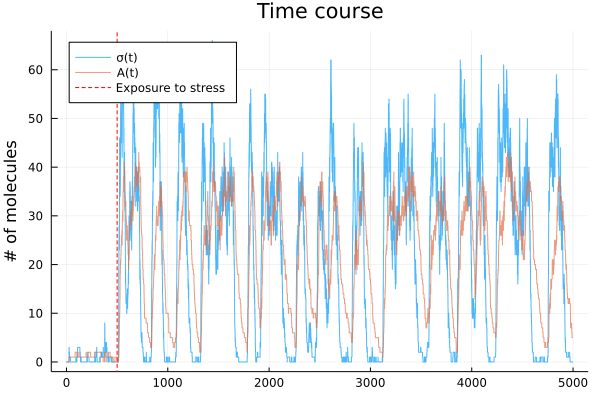

In [86]:
plot_timecourse(Sigma.Simu_solution(sol), pretrim_t = stress_t, title = "Time course", max_t = 5000.) |> display
#savefig("figures/2_5_algo_example_traj.pdf")

## Calculate and visualize the reconstructed vector field

After calculating for 100000 time points, the are still 1162 positions not converged.
After calculating for 200000 time points, the are still 791 positions not converged.
After calculating for 300000 time points, the are still 586 positions not converged.
After calculating for 400000 time points, the are still 429 positions not converged.
After calculating for 500000 time points, the are still 326 positions not converged.
After calculating for 600000 time points, the are still 250 positions not converged.
After calculating for 700000 time points, the are still 178 positions not converged.
After calculating for 800000 time points, the are still 147 positions not converged.
After calculating for 900000 time points, the are still 117 positions not converged.
After calculating for 1000000 time points, the are still 74 positions not converged.
After calculating for 1100000 time points, the are still 63 positions not converged.
The number of unconverged positions (47) satisfies unsatis_r aft

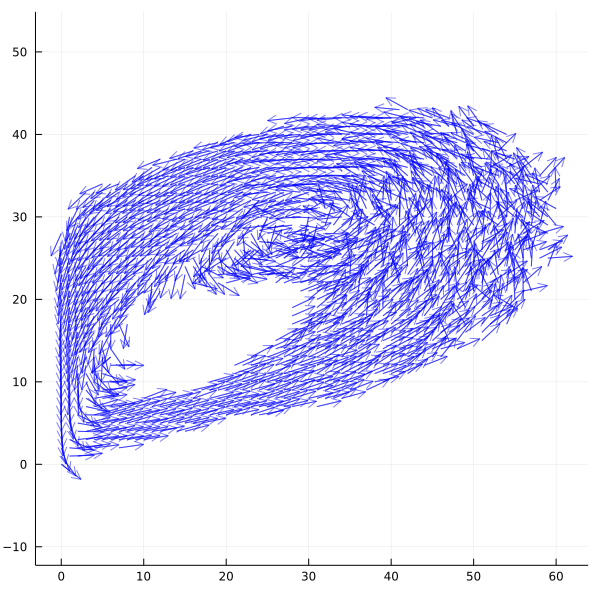

In [73]:
vf, N_vis = vector_field(Sigma.Simu_solution(sol), pretrim_t = stress_t, tol = 0.05, verbose = true);
dσdt = map(x -> x[1], vf)
dAdt = map(x -> x[2], vf)
#plot_vf(dσdt, dAdt, scale = 3, adaptive = false, interval = 1)

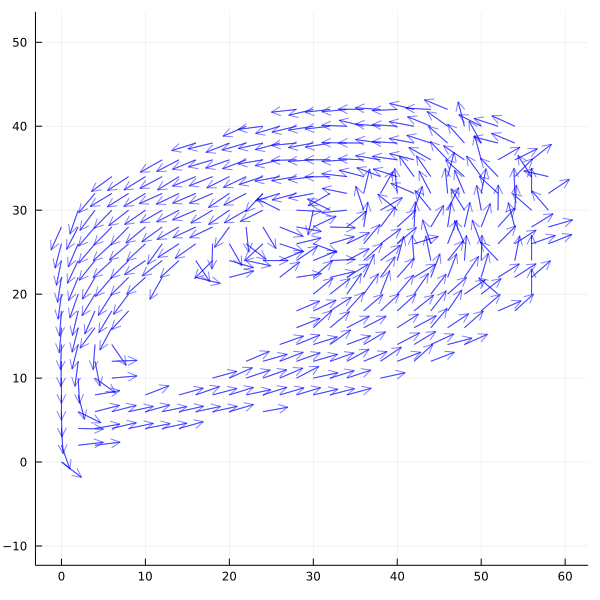

In [87]:
plot_vf(dσdt, dAdt, scale = 3, adaptive = false, interval = 2) |> display
#savefig("figures/2_5_algo_example_vf.pdf")

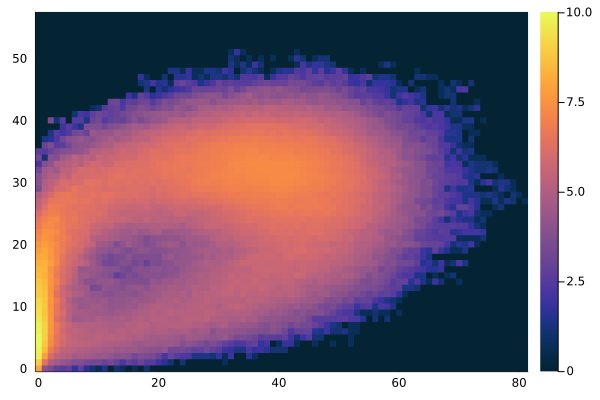

In [88]:
plot_N_vis(N_vis, c=:thermal) |> display
#savefig("figures/2_5_algo_example_density.pdf")

## The new library

TODO list

- [ ] Potentially move all functions to the module `Sigma`
- [ ] Give `vector_field` an example
- [x] Dirty vector field should be ignored


Defining the `struct Sigma`.

In [6]:
module Sigma

"""
A composite type for the result of the simulation
of a two-dimensional dynamical system.
It contains *trajectories of the two discrete variables* against *time*.

The purpose to have the type is to assert valid input for
a series of functions that relies on the solution of a smimulation.

The trajectories must integer-valued. Its benefit to simplify analyses
overcomes the flexibility for potential generalization.
"""
struct Simu_solution
    t::AbstractVector{<:Real}
    u::AbstractVector{<:AbstractVector{<:Integer}}
    
    """
        Simu_solution(sol)
    
    Convert the solution of a simulation, `sol`, to type `Sigma.Simu_solution`.
    
    Two fields are required in `sol`, `t`, an one-dimensional array of time points,
    and `u`, an array of array of *integers* storing the trajectories.
    `t` and `u` must be of the same length.
    """
    function Simu_solution(sol)
        # checking for the existence and type of u and t may be redundant
        
        # check for fields u and t
        if !hasproperty(sol, :u) || !hasproperty(sol, :t)    # notice that hasfield() accepts a TYPE
            error("A Simu_solution object failed to construct without the field u or t.")
        # check for the types of u and t
        elseif !isa(sol.u, AbstractVector{<:AbstractVector{<:Integer}}) || !isa(sol.t, AbstractVector{<:Real})
            error("A Simu_solution object failed to construct since field u must be a two-dimensional array of integers and field t must be an one-dimensional array of real numbers.")
        # check equal length of u and t
        elseif length(sol.u) != length(sol.t)
            error("A Simu_solution object failed to construct since the length of field u and t must be equal.")
        else
            new(sol.t, sol.u)
        end
    end
end;

end;

Plot the trajectories against time

In [7]:
"""
    plot_timecourse(sol::Sigma.Simu_solution; <keyword arguments>)

Plot the trajectory of a second-order (i.e., two-dimensional) system against time according
to the *solution* of a simulation, `sol`.

One can use `Sigma.Simu_solution(x)` to convert `x`, e.g. an `ODESolution` object,
to the appropriate input of this function.

The default is `alpha = 0.7` to show the overlapping of two trajectories.
One can revert it by passing `alpha = 1` to the function. 
The function also takes all other arguments that apply to `plot`.

# Arguments
- `pretrim_t`: The `pre-trimmed` time point, indicating that from 0 to it will be excluded from the following analysis. Notice that it still WILL show in the plot, but deoted by a dashed line
- `max_t=2000.0`: The maximum plotted time
- `show_vars=[1, 2]`: An indication of which variable(s) to show
- `labels=["σ(t)", "A(t)"]`: The label for each trajectory in the plot legend
- `kwargs`: Other keyword arguments that are passed to `plot`

# Example

```jl
# the example contains a pair of ``sin`` and ``-sin`` functions
# whose start point is moved to ``t = 3``
t = 1:0.1:10
u = [ [ [0., 0.] for i in 1:0.1:3 ]
    [ [sin(x), -sin(x)] for x in 0.1:0.1:7 ] ]
sol = (t = t, u = u)

plot_timecourse(Sigma.Simu_solution(sol); pretrim_t = 3.)
```
"""
function plot_timecourse(sol::Sigma.Simu_solution; 
        pretrim_t, max_t = 2000.0, show_vars = [1, 2], labels = ["σ(t)", "A(t)"], kwargs...)
    # check for sol is done by type assertion
    
    # check max_t and convert to max # of time steps
    dt = sol.t[2] - sol.t[1]    # assuming uniform time intervals
    max_tstp = Int(floor(max_t / dt))    # max time step, including max_t
    max_tstp = min(length(sol.t), max_tstp)    # prevent index out-of-bounds
    
    # filter the displaying variables
    sol_u_filtered = [ x[show_vars] for x in sol.u[1:max_tstp] ]    # max_tstp is exerted here
    
    # plot
    p = plot(sol.t[1:max_tstp], hcat(sol_u_filtered...)',    # hcat as a hack to convert array of array to 2D array
            alpha = 0.7,
            labels = reshape(labels[show_vars], 1, :),    # labels must be a row vector, in consistent with the fact that different y vectors are arranged along 2nd dimension
            ylabel = "# of molecules",
            legend = :topleft;
            kwargs...)
    # plot a dash vline at pretrim_t
    plot!(p, [pretrim_t],
        seriestype = :vline,
        color = :red,
        linestyle = :dash,
        labels = "Exposure to stress")
    
    return p
end;

Get the reconstructed vector field and trajectory density

In [8]:
"""
    traj_density(sol::Sigma.Simu_solution; pretrim_t)

Tally the trajectory density, i.e. the number of times that
the trajectory passes a point on the phase plane,
from the solution of a simulation `sol`.

The argument `pretrim_t` specifies the time point before which
the trajectory is excluded from the analysis.

Notice that it returns the unnormalized *raw counts* as the density.
One may want to keep a record of the length of the simulation to
scale the density accordingly.
"""
function traj_density(sol::Sigma.Simu_solution; pretrim_t)
    # get the number of states
    # we always call the 1st dim. σ and the 2nd sim. A
    N_σ_states = maximum(x -> x[1], sol.u) + 1    # +1 because the first state is 0
    N_A_states = maximum(x -> x[2], sol.u) + 1
    
    # initialize
    density = zeros(Float64, N_σ_states, N_A_states)
    
    # count
    for i in 1:length(sol.u)
        density[(sol.u[i] .+ 1)...] += 1    # (0, 0) state stores at density[1, 1]
    end
    
    return density
end;

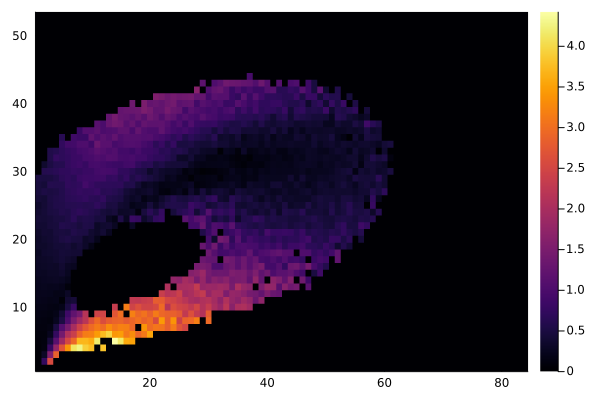

In [301]:
# magnitude = map(x -> sqrt(sum(x.^2)), vf)
# p_heatmap = heatmap(1:size(magnitude, 1), 1:size(magnitude, 2), magnitude')

In [55]:
"""
    vector_field(sol::Sigma.Simu_solution, <keyword arguments>)

Estimate the vector field of a stochastic reaction given its simulated trajectory.

The vectors are calculated by averaging the small changes of the trajectory around a lattice point over the 
times that the point is visited.
Though theoretically a stochastic reaction does not have a vector field, this estimation can
be useful in various phase plane analysis, e.g., finding fixed points.

# Arguments
-`pretrim_t`:Initial stage of the simulation until which the trajectory is trimmed and is removed from further analysis
-`max_t=1e8`: The maximum time to which the vector field is calculated. Ignored when `adaptive=true`
-`grad_size=1`: Δt for calculating a derivative. Default is 1 time step on both left and right side
-`adaptive=true`: Whether use adaptive criteria to terminate calculation. Adaptive is recommended.
-`tol=0.1`: Used with `adaptive=true`. Use this value to control the accuracy/stability of the results. A vector is *converged* if the Euclidean distance between its current value and the previous one is below `tol`
-`unsatis_r=0.01`: Used with `adaptive=true`. If the ratio of unconverged vectors is below `unsatis_r`, terminate. Usually don't change it
-`ignore_r_vis=`1e-4`: Used with `adaptive=true`. If the chance of a point being visited is below this value, ignore it when checking convergence. Usually don't change it
-`verbose=false`: Used with `adaptive=true`. Report convergence stats
"""
function vector_field(sol::Sigma.Simu_solution; 
        pretrim_t, max_t = 1e8, grad_size = 1, adaptive = true, tol = 0.1, unsatis_r = 0.01, ignore_r_vis = 1e-4, verbose = false)
    # preparations
    N_σ_states = maximum(x -> x[1], sol.u) + 1    # including 0. always include states of the entire simulation, though some may not be in the calculation
    N_A_states = maximum(x -> x[2], sol.u) + 1
    dt = sol.t[2] - sol.t[1]    # assuming uniform time intervals
    pretrim_tstp = Int64(floor(pretrim_t / dt))    # pre-trimmed time steps
    # max_tstp is only relavant if not adaptive. If adaptive, terminated by tol.
    if !adaptive
        max_tstp = Int64(floor(max_t / dt))    # max time steps
        max_tstp = min(max_tstp, length(sol.u))    # avoid exceeding (never happens here anyway)
    else
        LEAST_UPDATE = 10000    # even though adaptive, it should be updated for a least # of time points for tol condition to work
        REPORT_INT = 100000    # report interval
    end
    
    # initialize
    sum_grad = fill([0., 0.], N_σ_states, N_A_states)    # sum of gradients
    N_visited = zeros(Int64, N_σ_states, N_A_states)    # # of times visited. Similar concept to traj. density, but keeps updating
    if adaptive
        tol_satisfied = fill(false, N_σ_states, N_A_states)    # if gradient at each point satisfies tol (termination condition)
    end
    
    # dσ/dt = 1/n⋅∑[σ(t+Δt)-σ(t-Δt)]/2Δt, same for A
    for i in (pretrim_tstp + 1 + grad_size):(length(sol.u) - grad_size)    # always use symmetrical derivative, so ignore boundries
        grad = (sol.u[i + grad_size] - sol.u[i - grad_size]) / (2*dt*grad_size)    # gradient of current step of the traj.
        sum_grad[(sol.u[i] .+ 1)...] += grad
        N_visited[(sol.u[i] .+ 1)...] += 1
        
        # termination
        if !adaptive
            if i >= max_tstp    # N.B. max_t includes pretrim_t, though the latter is excluded
                break
            end
        else
            # termination condition is all ||Δ|| < tol
            # Δ(n+1) = S(n+1)/(n+1) - S(n)/n = 1/n⋅[q(n+1) - S(n+1)/(n+1)], where S is sum_grad and q is grad
            # update
            cur_N_visited = N_visited[(sol.u[i] .+ 1)...]    # # of times the current position is visited
            if cur_N_visited == 1
                diff = grad
            else    # > 1, cur_N_visited is at least 1
                diff = 1/(cur_N_visited-1) * (grad - sum_grad[(sol.u[i] .+ 1)...]/cur_N_visited)    # Δ of current position
            end
            tol_satisfied[(sol.u[i] .+ 1)...] = sqrt(sum(diff.^2)) < tol
            # check
            if i > LEAST_UPDATE
                # unconverted points are the ones that not satisfying tol and being visited at least once
                N_unconverged = sum(.!(tol_satisfied .| (N_visited .< i*ignore_r_vis)))
                if N_unconverged < N_σ_states*N_A_states*unsatis_r    # some rarely visited positions WILL have large Δ, which is permitted
                    if verbose
                        println("The number of unconverged positions ($N_unconverged) satisfies unsatis_r after $i time points visited.")
                    end
                    break
                end
                # report
                if verbose
                    if mod(i, REPORT_INT) == 0
                        println("After calculating for $i time points, the are still $N_unconverged positions not converged.")
                    end
                end
            end
        end
    end
    
    # filter out rarely visited and unconverged
    if adaptive
        filter_outs = .!(tol_satisfied .& (N_visited .> sum(N_visited)*ignore_r_vis))
        sum_grad[filter_outs] .= [[0., 0.]]    # array of array is required for the broadcasting here
    end
    
    # get mean
    N_visited_pos = N_visited .+ (N_visited .== 0)    # if never visited, add one to avoid divided by 0
    mean_grad = sum_grad ./ N_visited_pos
    
    return mean_grad, N_visited
end;

Plot the reconstructed vector field

In [69]:
"""
Vector field plot with quiver
please specify an interval or the plotting is extremely slow
and the vectors are clustered
"""
function plot_vf(dσdt, dAdt; scale = 1.0, interval = 5, adaptive = true, pkwargs...)
    # normalize
    magnitude = @. sqrt(dσdt^2 + dAdt^2)
    dσdt = dσdt ./ magnitude
    dAdt = dAdt ./ magnitude
    # ignore unvisited states
    ignore_σ = (sum(magnitude, dims=2) .< 1e-6) |> vec    # 1 x N matrix won't work
    ignore_A = (sum(magnitude, dims=1) .< 1e-6) |> vec
    dσdt = dσdt[.!ignore_σ, .!ignore_A]
    dAdt = dAdt[.!ignore_σ, .!ignore_A]
    
    # if adaptive = true, interval is override
    σ_size = size(dσdt, 1)
    A_size = size(dσdt, 2)
    # calculate interval
    if adaptive
        # be careful with small grid
        interval = max(Int64(round(min(σ_size, A_size) / 10)), 1)
    end
    # pick up the vectors to show
    dσdt = dσdt[1:interval:σ_size, 1:interval:A_size]
    dAdt = dAdt[1:interval:σ_size, 1:interval:A_size]
    
    
    # plot
    σ_grid = ((1:interval:σ_size) .- 1) * ones(1, Int64(ceil(A_size/interval)) )
    A_grid = ones(Int64(ceil(σ_size/interval)), 1) * ((1:interval:A_size) .- 1)'
    quiver(σ_grid[:], A_grid[:], quiver = (scale .* dσdt[:], scale .* dAdt[:]), 
        alpha = 0.5, color = "blue", aspect_ratio = :equal; pkwargs...)
    plot!(size = (600, 600))
end


"""
Plot frequency of visiting, heatmap"
"""
function plot_N_vis(N_vis; pkwargs...)
    N_vis = log.(N_vis .+ 1)
    heatmap(0:size(N_vis, 1) - 1, 0:size(N_vis, 2) - 1, N_vis'; pkwargs...)
end

plot_N_vis